**ФИО:** `Соломенцев А.С.`

# Домашняя работа № 1

**Цель:** обучить бинарный классификатор для поиска токсичного контента (твитов).

In [1]:
!pip install pymorphy2 nltk fasttext transformers

     |████████████████████████████████| 55 kB 2.4 MB/s 
     |████████████████████████████████| 68 kB 6.4 MB/s 
     |████████████████████████████████| 4.2 MB 44.8 MB/s 
     |████████████████████████████████| 8.2 MB 50.1 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
     |████████████████████████████████| 6.6 MB 58.4 MB/s 
     |████████████████████████████████| 596 kB 63.7 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3148428 sha256=7b1a751f79353341acc0b6eb645b04e11296a18191f555809ee717a6860546c0
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [35]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords
import fasttext

from transformers import BertTokenizer, BertForSequenceClassification, BertModel, AdamW, get_linear_schedule_with_warmup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('train_data.csv')
df['toxic'] = df.toxic.astype(int)
df.sample(10)

,comment,toxic
6564,"Ничего. Но всё меняется от того факта, что ты ...",1
5087,Без косметики лучше. Разрисованные по современ...,0
4425,"Как установил суд, банк занизил полную стоимос...",0
4793,Тут же ещё вопрос качества тех прививок. Во вс...,0
7051,"Русачки ебаные, какого хуя вы отдали Польше мо...",1
139,"Да норм магазин, в чем ажиотаж.\n",0
7996,"Москва не хочет этой войны, и тебе наш президе...",1
381,Я так до 3 класса глаза себе испортил.теперь в...,0
8392,"Как и мессенджер, но только вот он не везде та...",0
2520,"Не знаю, что он там вам показал, если вы не сп...",0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.comment, df.toxic, test_size=0.2, stratify=df.toxic)

In [5]:
df_train = pd.DataFrame(data=np.array([X_train, y_train]), index=['comment', 'toxic'], columns=X_train.index).T
df_test = pd.DataFrame(data= np.array([X_test, y_test]), index= ['comment', 'toxic'], columns= X_test.index).T

In [6]:
#  Baseline 4 - BoW для слов

vec = CountVectorizer(ngram_range=(1,1))
bow = vec.fit_transform(X_train)

In [7]:
list(vec.vocabulary_.items())[:10]

[('так', 42635),
 ('может', 21016),
 ('автор', 1892),
 ('фото', 46447),
 ('использовал', 15249),
 ('треногу', 43872),
 ('для', 10330),
 ('фотоаппарата', 46449),
 ('напомнил', 22331),
 ('спасибо', 40807)]

In [8]:
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(bow, y_train)
y_pred = clf.predict(vec.transform(X_test))
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(acc)
print(classification_report(y_true=y_test, y_pred=y_pred))

0.8385753931544866
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1440
           1       0.83      0.65      0.73       722

    accuracy                           0.84      2162
   macro avg       0.84      0.79      0.81      2162
weighted avg       0.84      0.84      0.83      2162



## baseline 2: preprocessing + bow -> 5

In [9]:
m = MorphAnalyzer()
regex = re.compile('[А-Яа-яA-z]+')

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

In [10]:
@lru_cache(128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

mystopwords = stopwords.words('russian')
def remove_stopwords(lemmas, stopwords= mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) >= 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

In [11]:
X_train_lem = list(tqdm(map(clean_text, X_train), total=len(X_train)))

df_train['lemmas'] = X_train_lem

df_train.sample()

100%|██████████| 8647/8647 [00:48<00:00, 179.51it/s]


,comment,toxic,lemmas
26,"Учебник , как учебник. Учат на русском языке. ...",0,учебник учебник учить русский язык очернение с...


In [12]:
X_test_lem = list(tqdm(map(clean_text, X_test), total=len(X_test)))

df_test['lemmas'] = X_test_lem

df_test.sample()

100%|██████████| 2162/2162 [00:07<00:00, 287.04it/s]


,comment,toxic,lemmas
6733,Основа промышленности области горно-металлурги...,0,основа промышленность область горный металлург...


In [13]:
vec = CountVectorizer(ngram_range=(1,2))
bow = vec.fit_transform(X_train_lem)

clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(bow, y_train)
y_pred = clf.predict(vec.transform(X_test_lem))
acc = accuracy_score(y_test, y_pred)
print(acc)
print(classification_report(y_test, y_pred))

0.8506012950971323
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1440
           1       0.88      0.64      0.74       722

    accuracy                           0.85      2162
   macro avg       0.86      0.80      0.82      2162
weighted avg       0.85      0.85      0.84      2162



## baseline 3: preproc + fasttext -> 6

In [14]:
with open('train.txt', 'w') as f:
    for comment, toxic in zip(X_train_lem, y_train):
        f.write(f'__label__{toxic} {comment.lower()}\n')

In [15]:
with open('test.txt', 'w') as f:
    for comment, toxic in zip(X_test_lem, y_test):
        f.write(f'__label__{toxic} {comment.lower()}\n')

In [16]:
classifier = fasttext.train_supervised('train.txt')
result = classifier.test('test.txt')
print(result)

(2162, 0.8612395929694727, 0.8612395929694727)


In [17]:
pred = classifier.predict(X_test_lem)
new_pred = [int(line[0][-1]) for line in pred[0]]
acc = accuracy_score(y_test, new_pred)
print(acc)
print(classification_report(y_test, new_pred))

0.8612395929694727
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1440
           1       0.85      0.71      0.77       722

    accuracy                           0.86      2162
   macro avg       0.86      0.82      0.84      2162
weighted avg       0.86      0.86      0.86      2162



## UPPER baseline 3: BERT (SkolkovoInstitute)

In [18]:
# load tokenizer and model weights
tokenizer = BertTokenizer.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')
model = BertForSequenceClassification.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')

Downloading:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/585 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/679M [00:00<?, ?B/s]

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)

cuda:0


In [20]:
def predict_label(comment, model=model, tokenizer=tokenizer):
  inputs = tokenizer.encode(comment, return_tensors='pt', max_length=512, truncation=True).to(device)

  with torch.no_grad():
    logits = model(inputs).logits
  
  predicted_class_id = logits.argmax().item()

  return predicted_class_id

In [21]:
y_pred_train = list(tqdm(map(predict_label, df_train.comment), total=len(df_train.comment)))

acc = accuracy_score(y_train, y_pred_train)
print(f'\nTrain data accuracy score without training – {acc}')
print(classification_report(y_train, y_pred_train))

100%|██████████| 8647/8647 [01:37<00:00, 88.64it/s]


Train data accuracy score without training – 0.9331560078639991
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5761
           1       0.93      0.86      0.90      2886

    accuracy                           0.93      8647
   macro avg       0.93      0.92      0.92      8647
weighted avg       0.93      0.93      0.93      8647



In [22]:
y_pred = list(tqdm(map(predict_label, df_test.comment), total=len(df_test.comment)))
acc = accuracy_score(y_test, y_pred)
print(f'\nTest data accuracy score without training – {acc}')
print(classification_report(y_test, y_pred))

100%|██████████| 2162/2162 [00:23<00:00, 90.19it/s]


Test data accuracy score without training – 0.9380203515263644
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1440
           1       0.94      0.87      0.90       722

    accuracy                           0.94      2162
   macro avg       0.94      0.92      0.93      2162
weighted avg       0.94      0.94      0.94      2162



## UPPER Baseline 3: BERT updated with HW data 

In [23]:
# load BERT model weights for training
tokenizer = BertTokenizer.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')
model = BertModel.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')

Some weights of the model checkpoint at SkolkovoInstitute/russian_toxicity_classifier were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
MAX_LEN = 512
BATCH_SIZE = 8

class GPReviewDataset(Dataset):

  def __init__(self, comments, toxics, tokenizer, max_len):
    self.comments = comments
    self.toxics = toxics
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.comments)
  
  def __getitem__(self, item):
    comment = str(self.comments[item])
    toxic = self.toxics[item]

    encoding = self.tokenizer.encode_plus(
      comment,
      add_special_tokens=True,
      truncation= True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'comment_text': comment,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'toxic': torch.tensor(toxic, dtype=torch.long)
    }


def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    comments=df.comment.to_numpy(),
    toxics=df.toxic.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [25]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = model
    self.drop = nn.Dropout(p=0.2)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    ).pooler_output
    output = self.drop(pooled_output)
    return self.out(output)

In [26]:
# data = next(iter(train_data_loader))
# data.keys()

In [27]:
# print(data['input_ids'].shape)
# print(data['attention_mask'].shape)
# print(data['toxic'].shape)

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


model_bert = SentimentClassifier(2)
model_bert = model_bert.to(device)

cuda:0


In [29]:
# input_ids = data['input_ids'].to(device)
# attention_mask = data['attention_mask'].to(device)

# print(input_ids.shape) # batch size x seq length
# print(attention_mask.shape) # batch size x seq length

In [30]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [31]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    toxics = d["toxic"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, toxics)

    correct_predictions += torch.sum(preds == toxics)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [32]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      toxics = d["toxic"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, toxics)

      correct_predictions += torch.sum(preds == toxics)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [33]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model_bert,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  test_acc, test_loss = eval_model(
    model_bert,
    test_data_loader,
    loss_fn, 
    device, 
    len(df_test)
  )

  print(f'Test loss {test_loss} accuracy {test_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  if test_acc > best_accuracy:
    torch.save(model_bert.state_dict(), 'best_model_state.bin')
    best_accuracy = test_acc

Epoch 1/10
----------
Train loss 0.2578498221901857 accuracy 0.9299178905978953
Test loss 0.2081964447088299 accuracy 0.946808510638298

Epoch 2/10
----------
Train loss 0.09361460575619393 accuracy 0.9803400023129409
Test loss 0.29840155420189113 accuracy 0.9426456984273821

Epoch 3/10
----------
Train loss 0.04628992932861286 accuracy 0.9916734127443044
Test loss 0.4012690570826833 accuracy 0.9384828862164662

Epoch 4/10
----------
Train loss 0.025687702478799538 accuracy 0.9958367063721523
Test loss 0.4269357670994855 accuracy 0.9320074005550417

Epoch 5/10
----------
Train loss 0.01825737956605264 accuracy 0.9965305886434602
Test loss 0.591876570259986 accuracy 0.9176688251618872

Epoch 6/10
----------
Train loss 0.013023849380422338 accuracy 0.9969931768243322
Test loss 0.6841855747731687 accuracy 0.9250693802035153

Epoch 7/10
----------
Train loss 0.011170907540366086 accuracy 0.9980340002312942
Test loss 0.5771674309897517 accuracy 0.9320074005550417

Epoch 8/10
----------
Trai

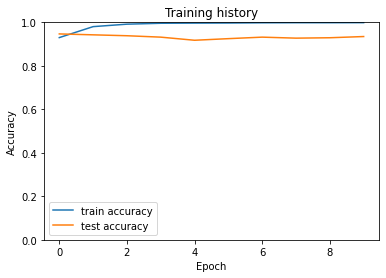

In [41]:
train_acc_history = np.array(list(map(lambda x: x.cpu(), history['train_acc'])))
test_acc_history = np.array(list(map(lambda x: x.cpu(), history['test_acc'])))

plt.plot(train_acc_history, label='train accuracy')
plt.plot(test_acc_history, label='test accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [44]:
# Load best model

model_bert = SentimentClassifier(2)
model_bert.load_state_dict(torch.load('best_model_state.bin'))
model_bert = model_bert.to(device)

In [45]:
test_acc, _ = eval_model(
  model_bert,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.946808510638298

In [46]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  comment_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      comments = d["comment_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      toxics = d["toxic"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      comment_texts.extend(comments)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(toxics)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return comment_texts, predictions, prediction_probs, real_values

In [47]:
y_comment_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model_bert,
  test_data_loader
)

In [49]:
acc = accuracy_score(y_test, y_pred)
print(f'Test data accuracy score with training – {acc}')
print(classification_report(y_test, y_pred))

Test data accuracy score with training – 0.9468085106382979
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1440
           1       0.94      0.90      0.92       722

    accuracy                           0.95      2162
   macro avg       0.94      0.94      0.94      2162
weighted avg       0.95      0.95      0.95      2162



## Подготовка ответа для отправки

In [57]:
# download test data

final_df = pd.read_csv('test_data.csv')
final_df['toxic'] = np.zeros(len(final_df), dtype=int)
final_df.head()

,comment_id,comment,toxic
0,0,"В данном случае не пионервожатая, а техничка, ...",0
1,1,В данном посте рассматривается обычный ленточн...,0
2,2,"Как я понимаю, у поверхностей отражаемость пог...",0
3,3,Австралийские пауки съедят все живое на планете)),0
4,4,У нас раньше Амур пиво целые бутылки принимал ...,0


In [70]:
# prepare data for prediction
final_data_loader = create_data_loader(final_df, tokenizer, MAX_LEN, BATCH_SIZE)

# get predictions
final_comment_texts, final_pred, final_pred_probs, y_test_none = get_predictions(
  model_bert,
  final_data_loader
)

# save predictions
sample_submission = pd.DataFrame(data= [final_df.comment_id, np.array(final_pred)], index=['comment_id', 'toxic']).T
sample_submission.to_csv('sample_submission.csv', index=False)